In [1]:
# @title Path Setup and Imports { display-mode: "form" }
# @markdown (double click to show code).

%cd ../

/coc/pskynet3/hagrawal9/project/habitat/habitat-api/notebooks


In [2]:
import sys
# sys.path = sys.path[1:]

In [3]:
sys.path

['/srv/share3/hagrawal9/project/habitat/habitat-api',
 '/srv/share3/hagrawal9/project/habitat/habitat-sim',
 '/coc/pskynet3/hagrawal9/project/habitat/habitat-api/notebooks/sokoban',
 '/srv/share3/hagrawal9/envs/habitat/lib/python36.zip',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/lib-dynload',
 '',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/site-packages',
 '/coc/pskynet3/hagrawal9/project/habitat/habitat-api',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/site-packages/tensorflow-1.13.1-py3.6-linux-x86_64.egg',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/site-packages/tb_nightly-2.4.0a20200812-py3.6.egg',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/site-packages/moviepy-2.0.0.dev1-py3.6.egg',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/site-packages/wheel-0.34.2-py3.6.egg',
 '/srv/share3/hagrawal9/envs/habitat/lib/python3.6/site-packages/tensorflow_estimator-1.13.0-py3.6.egg',
 '/srv/share3/

In [4]:
## [setup]
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat_sim.utils.common import *

if "google.colab" in sys.modules:
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
%cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument(
        "--no-make-video", dest="make_video", action="store_false"
    )
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    make_video = args.make_video
else:
    show_video = False
    make_video = False
    display = False

if make_video and not os.path.exists(output_path):
    os.makedirs(output_path)

/coc/pskynet3/hagrawal9/project/habitat/habitat-api


In [1]:
from habitat_sim.physics import MotionType

In [5]:
# @title Util functions to visualize observations
# @markdown - `make_video_cv2`: Renders a video from a list of observations
# @markdown - `simulate`: Runs simulation for a given amount of time at 60Hz
# @markdown - `simulate_and_make_vid` Runs simulation and creates video


def make_video_cv2(
    observations, cross_hair=None, prefix="", open_vid=True, fps=60
):
    sensor_keys = list(observations[0])
    videodims = observations[0][sensor_keys[0]].shape
    videodims = (videodims[1], videodims[0])  # flip to w,h order
    print(videodims)
    video_file = output_path + prefix + ".mp4"
    print("Encoding the video: %s " % video_file)
    writer = vut.get_fast_video_writer(video_file, fps=fps)
    for ob in observations:
        # If in RGB/RGBA format, remove the alpha channel
        rgb_im_1st_person = cv2.cvtColor(ob["rgb"], cv2.COLOR_RGBA2RGB)
        if cross_hair is not None:
            rgb_im_1st_person[
                cross_hair[0] - 2 : cross_hair[0] + 2,
                cross_hair[1] - 2 : cross_hair[1] + 2,
            ] = [255, 0, 0]

        if rgb_im_1st_person.shape[:2] != videodims:
            rgb_im_1st_person = cv2.resize(
                rgb_im_1st_person, videodims, interpolation=cv2.INTER_AREA
            )
        # write the 1st person observation to video
        writer.append_data(rgb_im_1st_person)
    writer.close()

    if open_vid:
        print("Displaying video")
        vut.display_video(video_file)


def simulate(sim, dt=1.0, get_frames=True):
    # simulate dt seconds at 60Hz to the nearest fixed timestep
    print("Simulating " + str(dt) + " world seconds.")
    observations = []
    start_time = sim.get_world_time()
    while sim.get_world_time() < start_time + dt:
        sim.step_physics(1.0 / 60.0)
        if get_frames:
            observations.append(sim.get_sensor_observations())
    return observations


# convenience wrapper for simulate and make_video_cv2
def simulate_and_make_vid(sim, crosshair, prefix, dt=1.0, open_vid=True):
    observations = simulate(sim, dt)
    make_video_cv2(observations, crosshair, prefix=prefix, open_vid=open_vid)


def display_sample(
    rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([]), key_points=None
):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new(
            "P", (semantic_obs.shape[1], semantic_obs.shape[0])
        )
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray(
            (depth_obs / 10 * 255).astype(np.uint8), mode="L"
        )
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(24, 16))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        # plot points on images
        if key_points is not None and i==0:
            for pix, point in enumerate(key_points):
                plt.plot(
                    point[0], point[1], marker="o", markersize=10, alpha=0.8
                )
        plt.imshow(data)
    plt.tight_layout()
    plt.savefig('vis.png')
    plt.show(block=False)

## 1. Setup the Simulator

---



In [6]:
# @title Setup simulator configuration
# @markdown We'll start with setting up simulator with the following configurations
# @markdown - The simulator will render both RGB, Depth observations of 256x256 resolution.
# @markdown - The actions available will be `move_forward`, `turn_left`, `turn_right`.


def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.default_agent_id = settings["default_agent_id"]
    sim_cfg.scene.id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]
    sim_cfg.physics_config_file = settings["physics_config_file"]

    # Note: all sensors must have the same resolution
    sensors = {
        "rgb": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
    }

    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.SensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]

            sensor_specs.append(sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.1)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=10.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=10.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])
        
settings = {
    "max_frames": 10,
    "width": 640,
    "height": 480,
    "hfov": 79,
    "scene": "data/scene_datasets/gibson_train_val/Barboursville.glb",
    "default_agent_id": 0,
    "sensor_height": 0.88,  # Height of sensors in meters
    "rgb": True,  # RGB sensor
    "depth": True,  # Depth sensor
    "seed": 1,
    "enable_physics": True,
    "physics_config_file": "data/default.phys_scene_config.json",
    "silent": False,
    "compute_shortest_path": False,
    "compute_action_shortest_path": False,
    "save_png": True,
}

cfg = make_cfg(settings)

In [7]:
# @title Spawn the agent at a pre-defined location

def init_agent(sim):
    agent_pos = np.array([0.39638743, 0.1543742, 4.1197767])
    
    # Place the agent
    # agent_pos = sim.pathfinder.get_random_navigable_point()
    sim.agents[0].scene_node.translation = agent_pos
    agent_orientation_y = 0
    sim.agents[0].scene_node.rotation = mn.Quaternion.rotation(
        mn.Deg(agent_orientation_y), mn.Vector3(0, 1.0, 0)
    )

In [8]:
def remove_all_objects(sim):
    for id in sim.get_existing_object_ids():
        sim.remove_object(id)


def set_object_in_front_of_agent(sim, obj_id, z_offset=-1.5, rot_offset=0):
    r"""
    Adds an object in front of the agent at some distance.
    """
    agent_transform = sim.agents[0].scene_node.transformation_matrix()
    T = agent_transform.rotation_y(mn.Deg(rot_offset))
    T.translation = agent_transform.translation

    obj_translation = T.transform_point(
        np.array([0, 0, z_offset])
    )
    sim.set_translation(obj_translation, obj_id)

    obj_node = sim.get_object_scene_node(obj_id)
    xform_bb = habitat_sim.geo.get_transformed_bb(
        obj_node.cumulative_bb, obj_node.transformation
    )

    # also account for collision margin of the scene
    scene_collision_margin = 0.04
    y_translation = mn.Vector3(
        0, xform_bb.size_y() / 2.0 + scene_collision_margin, 0
    )
    sim.set_translation(y_translation + sim.get_translation(obj_id), obj_id)

def init_objects(sim):
    # Manager of Object Attributes Templates
    obj_attr_mgr = sim.get_object_template_manager()

    # Add a chair into the scene.
    obj_path = "data/test_assets/objects/chair.glb"
    chair_template_id = obj_attr_mgr.load_object_configs(
        str(os.path.join(data_path, obj_path))
    )[0]
    chair_attr = obj_attr_mgr.get_template_by_ID(chair_template_id)
    obj_attr_mgr.register_template(chair_attr)

    # Object's initial position 3m away from the agent.
    object_id = sim.add_object_by_handle(chair_attr.handle)
    set_object_in_front_of_agent(sim, object_id, -3.0)
    sim.set_object_motion_type(
        habitat_sim.physics.MotionType.STATIC, object_id
    )

    # Object's final position 7m away from the agent
    goal_id = sim.add_object_by_handle(chair_attr.handle)
    set_object_in_front_of_agent(sim, goal_id, -7.0)
    sim.set_object_motion_type(habitat_sim.physics.MotionType.STATIC, goal_id)

    return object_id, goal_id

In [9]:
DESIRED_DIM = 0.3

def render_object(sim, sel_file_obj_handle, z_offset, rot_offset, remove_object=True):
    if remove_object:
        remove_all_objects(sim)

    obj_handle = os.path.basename(sel_file_obj_handle).split('.')[0]
    object_handle = obj_attr_mgr.get_file_template_handles(obj_handle)[0]

    obj_template = obj_attr_mgr.get_template_by_handle(object_handle)
    obj_template.scale = np.array([1.0, 1.0, 1.0])
    obj_attr_mgr.register_template(obj_template)

    object_id = sim.add_object_by_handle(object_handle)

    rotation_x = mn.Quaternion.rotation(mn.Deg(-90), mn.Vector3(1.0, 0, 0))
    rotation_y = mn.Quaternion.rotation(mn.Deg(90), mn.Vector3(0.0, 1.0, 0))
    rotation_z = mn.Quaternion.rotation(mn.Deg(0), mn.Vector3(0.0, 0, 1.0))
    # rotation_x1 = mn.Quaternion.rotation(mn.Deg(-45), mn.Vector3(1.0, 0, 0))
    orientation = rotation_z * rotation_y * rotation_x

    sim.set_rotation(orientation, object_id)
    set_object_in_front_of_agent(sim, object_id, z_offset, rot_offset)
    
    obj_node = sim.get_object_scene_node(0)
    xform_bb = habitat_sim.geo.get_transformed_bb(
        obj_node.cumulative_bb, obj_node.transformation
    )
    
    max_dim = np.max([xform_bb.size()[0], xform_bb.size()[2]])
    scaling_factor = np.max([1, (DESIRED_DIM / max_dim)])
    sim.remove_object(object_id)
    
    obj_template.scale = np.array([1.0, 1.0, 1.0])*scaling_factor
    
    print(obj_template.scale, scaling_factor, max_dim, DESIRED_DIM)
    obj_attr_mgr.register_template(obj_template)

    
    object_id = sim.add_object_by_handle(object_handle)

    rotation_x = mn.Quaternion.rotation(mn.Deg(-90), mn.Vector3(1.0, 0, 0))
    rotation_y = mn.Quaternion.rotation(mn.Deg(90), mn.Vector3(0.0, 1.0, 0))
    rotation_z = mn.Quaternion.rotation(mn.Deg(0), mn.Vector3(0.0, 0, 1.0))
    # rotation_x1 = mn.Quaternion.rotation(mn.Deg(-45), mn.Vector3(1.0, 0, 0))
    orientation = rotation_z * rotation_y * rotation_x

    sim.set_rotation(orientation, object_id)
    set_object_in_front_of_agent(sim, object_id, z_offset, rot_offset)

    
    sim.set_object_motion_type(habitat_sim.physics.MotionType.STATIC, object_id)
    print(obj_handle, object_id)
    
    if make_video:
        obs = sim.get_sensor_observations()
        print(obs['rgb'].shape)
        display_sample(
            obs['rgb'], semantic_obs=np.array([]), depth_obs=obs['depth'], key_points=[[320, 240]]
        )
    
    return (
        sel_file_obj_handle, {
            'scale': np.array(obj_template.scale).tolist(),
            'orientation': quat_to_coeffs(quat_from_magnum(orientation)).tolist()
        }
    )

In [10]:
from habitat.tasks.utils import cartesian_to_polar
from habitat.utils.geometry_utils import (
    quaternion_from_coeff,
    quaternion_rotate_vector,
)
def _compute_pointgoal(
    source_position, source_rotation, goal_position
):
    direction_vector = goal_position - source_position
    direction_vector_agent = quaternion_rotate_vector(
        source_rotation.inverse(), direction_vector
    )

    rho, phi = cartesian_to_polar(
        -direction_vector_agent[2], direction_vector_agent[0]
    )
    return np.array([rho, -phi], dtype=np.float32)

In [11]:
try:
    if sim:
        sim.close()
except Exception as e:
    pass 
  
sim = habitat_sim.Simulator(cfg) 
init_agent(sim)


# Manager of Object Attributes Templates
obj_attr_mgr = sim.get_object_template_manager()
handles = obj_attr_mgr.get_file_template_handles()

I1001 02:33:43.176752 14754 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Barboursville.navmesh


In [12]:
object_templates = []

Vector(2.926, 2.926, 2.926) 2.926000027904511 0.10252904891967773 0.3
002_master_chef_can 0
(480, 640, 4)


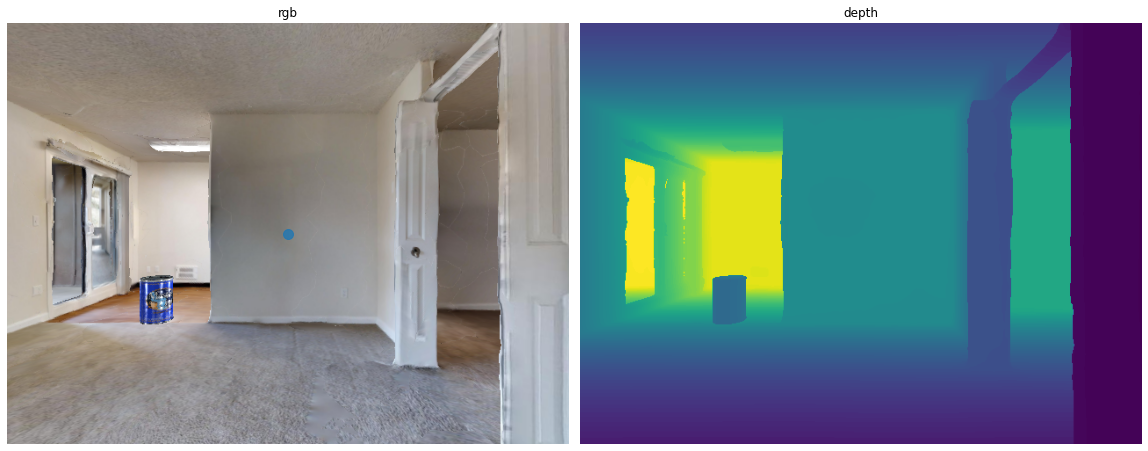

Vector(1, 1, 1) 1.0000001589457446 0.2999999523162842 0.3
003_cracker_box 1
(480, 640, 4)


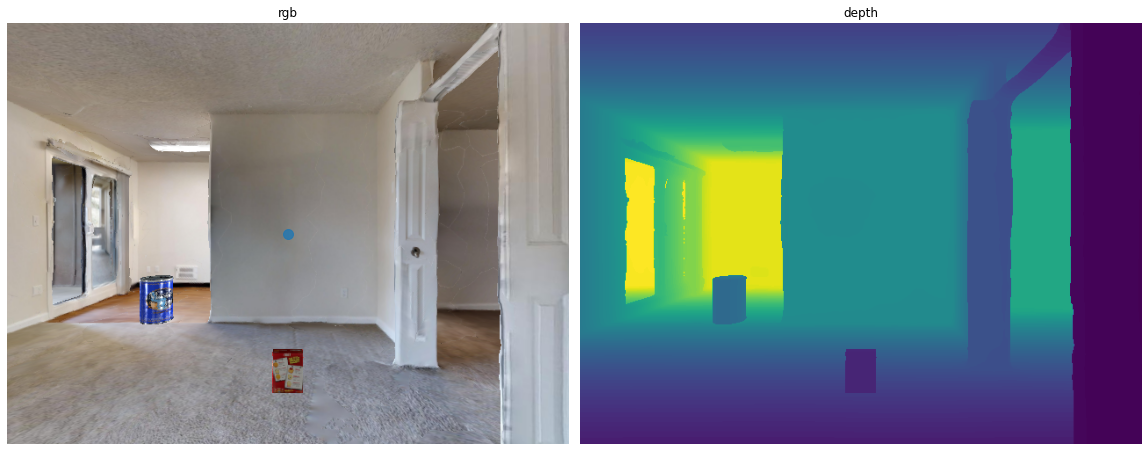

array([3.        , 0.43633232], dtype=float32)

In [13]:
sel_file_obj_handle = handles[0]
object_info = render_object(sim, sel_file_obj_handle, -3.0, 25)
object_info = render_object(sim, handles[1], -1.5, 0, remove_object=False)
obj_node = sim.get_object_scene_node(0)
xform_bb1 = habitat_sim.geo.get_transformed_bb(
    obj_node.cumulative_bb, obj_node.transformation
)
_compute_pointgoal(
    sim.agents[0].scene_node.translation, 
    quat_from_magnum(sim.agents[0].scene_node.rotation), 
    obj_node.translation
)

agent_orientation_y = 0
sim.agents[0].scene_node.rotation = mn.Quaternion.rotation(
    mn.Deg(agent_orientation_y), mn.Vector3(0, 1.0, 0)
)

_compute_pointgoal(
    sim.agents[0].scene_node.translation, 
    quat_from_magnum(sim.agents[0].scene_node.rotation), 
    obj_node.translation
)


In [ ]:
sim.

In [15]:
from habitat.utils.visualizations import maps

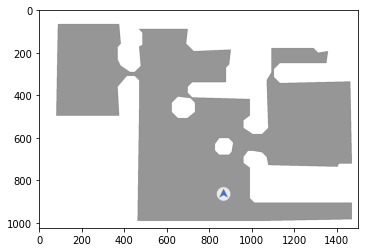

In [28]:
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.set_defaults()
navmesh_settings.agent_radius = 0.2
navmesh_settings.agent_height = 0.88
navmesh_settings.agent_max_climb = 0.1

sim.recompute_navmesh(sim.pathfinder, navmesh_settings, True)

top_down_map = maps.get_topdown_map(
    sim.pathfinder,
    sim.get_agent(0).state.position[1],
    1024
)

top_down_map = maps.colorize_topdown_map(top_down_map)
agent_position = sim.get_agent(0).state.position
ref_rotation = sim.get_agent(0).state.rotation

heading_vector = quaternion_rotate_vector(
    ref_rotation.inverse(), np.array([0, 0, -1])
)

phi = cartesian_to_polar(-heading_vector[2], heading_vector[0])[1]
z_neg_z_flip = np.pi
agent_rotation = np.array(phi) + z_neg_z_flip

a_x, a_y = maps.to_grid(
    agent_position[2],
    agent_position[0],
    top_down_map.shape[0:2],
    sim=sim,
)
top_down_map = maps.draw_agent(
    image=top_down_map,
    agent_center_coord=[a_x, a_y],
    agent_rotation=agent_rotation,
    agent_radius_px=min(top_down_map.shape[0:2]) / 32,
)


object_positions = []
for object_id in sim.get_existing_object_ids():
    object_positions.append(np.array(sim.get_translation(object_id)))

grid_object_positions = []

for i, obj_pos in enumerate(object_positions):
    tdm_pos = maps.to_grid(
        obj_pos[2],
        obj_pos[0],
        top_down_map.shape[0:2],
        sim=sim,
    )
    grid_object_positions.append(tdm_pos)


# top_down_map = maps.draw_object_info(top_down_map, grid_object_positions, [])

plt.imshow(top_down_map)

In [30]:
sim.pathfinder.is_navigable(object_positions[0])

False

In [13]:
selected_handles = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 30, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 71, 75, 77]

In [ ]:
object_templates = {}
for i, idx in enumerate(selected_handles):
    sel_file_obj_handle = handles[idx]
    print(i, sel_file_obj_handle)
    template_name, template_info = render_object(sim, sel_file_obj_handle, -1.5, 0)
    object_templates[template_name] = template_info

In [15]:
with open('data/ycb_object_templates.json', 'w') as f:
    json.dump(object_templates, f)

In [ ]:
sim.close()